In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


### Initial phase--draft

In [9]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

def extract_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks_array = [[landmark.x, landmark.y, landmark.z] for landmark in landmarks]
        return landmarks_array
    return None

def landmarks_to_heatmap(landmarks, img_size=(128, 128), blob_size=5):
    heatmap = np.zeros(img_size)
    for landmark in landmarks:
        x, y = int(landmark[0] * img_size[0]), int(landmark[1] * img_size[1])
        cv2.circle(heatmap, (x, y), blob_size, (255, 255, 255), -1)
    return heatmap

def preprocess_image(img, img_size=(128, 128)):
    landmarks = extract_hand_landmarks(img)
    if landmarks:
        heatmap = landmarks_to_heatmap(landmarks, img_size)
        return heatmap / 255.0
    return None
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
def load_images_from_folder(folder_name):
    images = []
    labels = []
    for filename in os.listdir(folder_name):
        img = cv2.imread(os.path.join(folder_name, filename))
        if img is not None:
            images.append(img)
            labels.append(folder_name)
    return images, labels

img_size = (128, 128)
all_images = []
all_labels = []

root_dataset_path = 'D:/B Tech/IV Year/project/project new/new dataset2'
for gesture_name in os.listdir(root_dataset_path):
    images, labels = load_images_from_folder(os.path.join(root_dataset_path, gesture_name))
    all_images.extend(images)
    all_labels.extend(labels)

preprocessed_data = [preprocess_image(img, img_size) for img in all_images]
processed_images, all_labels = zip(*[(data, label) for data, label in zip(preprocessed_data, all_labels) if data is not None])

unique_labels = list(set(all_labels))
int_labels = [unique_labels.index(label) for label in all_labels]

X_train, X_temp, y_train, y_temp = train_test_split(processed_images, int_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fit the Data Generator
X_train_reshaped = np.array(X_train).reshape((-1, img_size[0], img_size[1], 1))
datagen.fit(X_train_reshaped)
l2_strength = 0.01
feature_extractor = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength), input_shape=img_size + (1,)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(len(unique_labels), activation='softmax', kernel_regularizer=l2(l2_strength))
])

feature_extractor.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
batch_size = 16
history = feature_extractor.fit(datagen.flow(X_train_reshaped, to_categorical(y_train, num_classes=len(unique_labels)), batch_size=batch_size),
                                epochs=120,
                                validation_data=(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)),
                                                 to_categorical(y_val, num_classes=len(unique_labels))),
                                callbacks=[early_stopping])

feature_extractor.pop()
X_train_features = feature_extractor.predict(np.array(X_train).reshape((-1, img_size[0], img_size[1], 1)))
X_val_features = feature_extractor.predict(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)))
X_test_features = feature_extractor.predict(np.array(X_test).reshape((-1, img_size[0], img_size[1], 1)))

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_features, y_train)

y_val_pred = dt_classifier.predict(X_val_features)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_accuracy}")

y_test_pred = dt_classifier.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/120
11/11 [==============================] - 8s 464ms/step - loss: 3.0412 - accuracy: 0.0932 - val_loss: 2.8939 - val_accuracy: 0.1714
Epoch 2/120
11/11 [==============================] - 5s 401ms/step - loss: 2.8837 - accuracy: 0.1118 - val_loss: 2.8811 - val_accuracy: 0.0857
Epoch 3/120
11/11 [==============================] - 4s 398ms/step - loss: 2.7742 - accuracy: 0.1739 - val_loss: 2.7054 - val_accuracy: 0.0857
Epoch 4/120
11/11 [==============================] - 5s 406ms/step - loss: 2.6861 - accuracy: 0.1677 - val_loss: 2.5574 - val_accuracy: 0.1143
Epoch 5/120
11/11 [==============================] - 5s 421ms/step - loss: 2.6514 - accuracy: 0.1118 - val_loss: 2.5458 - val_accuracy: 0.1714
Epoch 6/120
11/11 [==============================] - 5s 403ms/step - loss: 2.5483 - accuracy: 0.1056 - val_loss: 2.4891 - val_accuracy: 0.2571
Epoch 7/120
11/11 [==============================] - 5s 407ms/step - loss: 2.4878 - accuracy: 0.1677 - val_loss: 2.3482 - val_accuracy: 0.2857

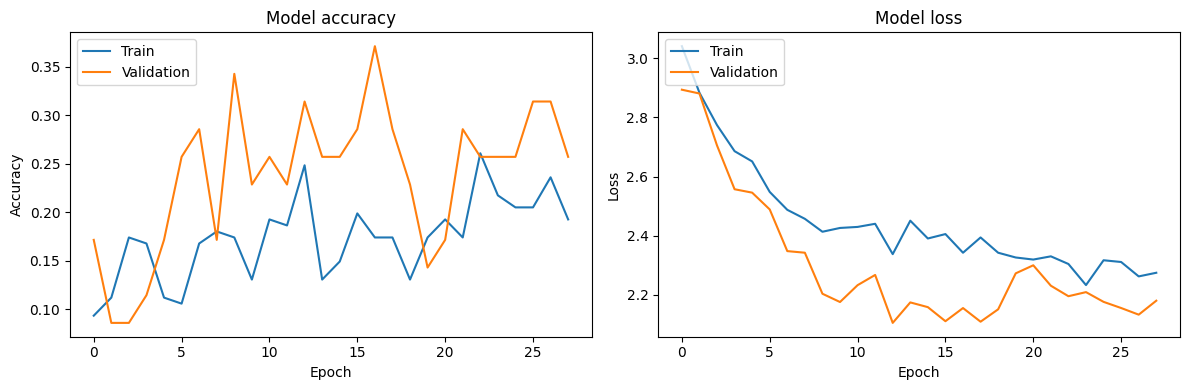

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


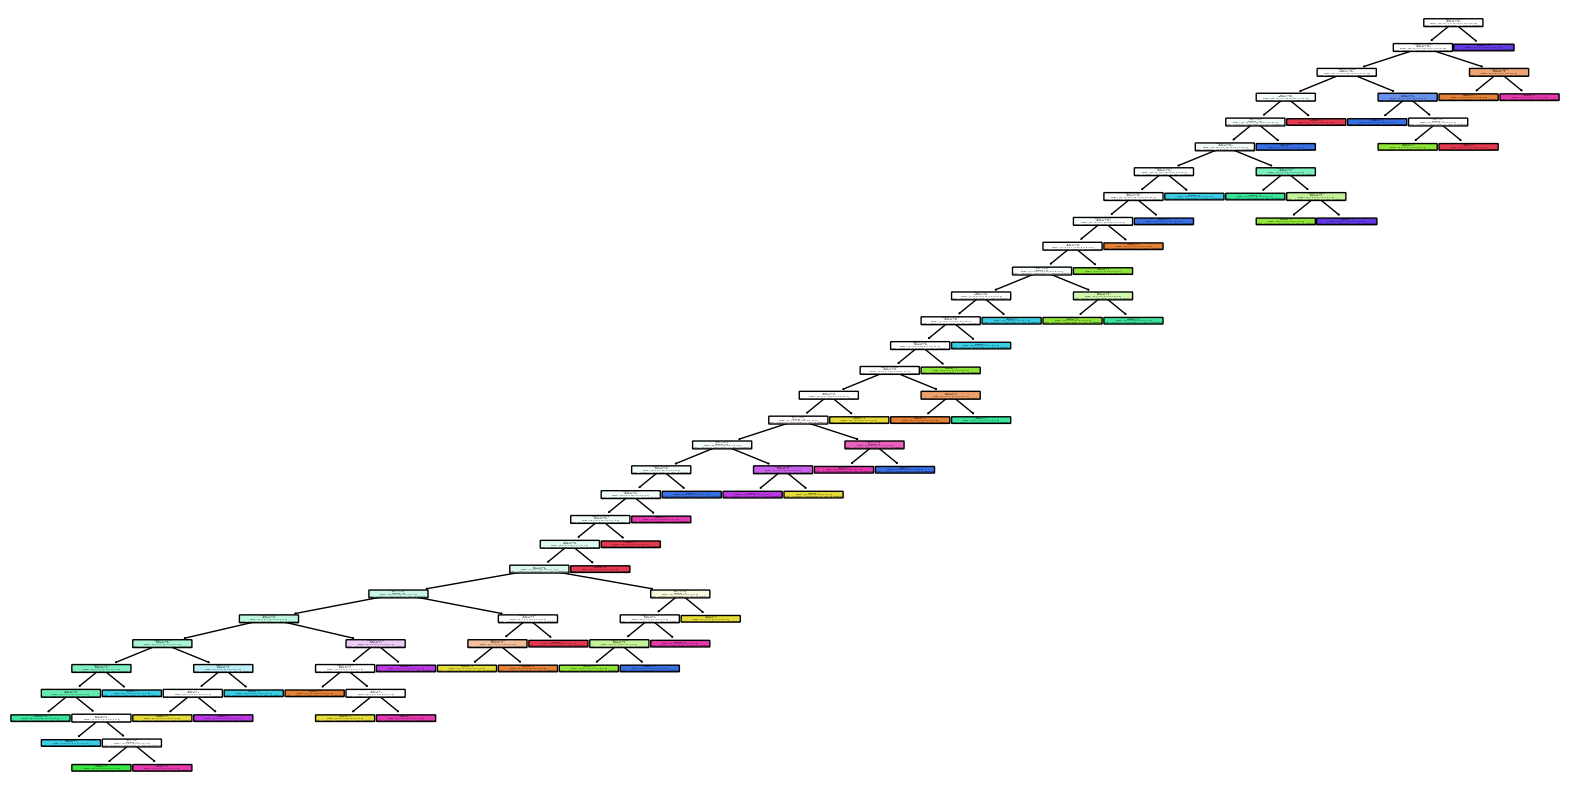

In [11]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dt_classifier, filled=True, feature_names=["f"+str(i) for i in range(X_train_features.shape[1])], class_names=[str(i) for i in unique_labels], rounded=True)
plt.show()


Found 417 valid images in the directory.


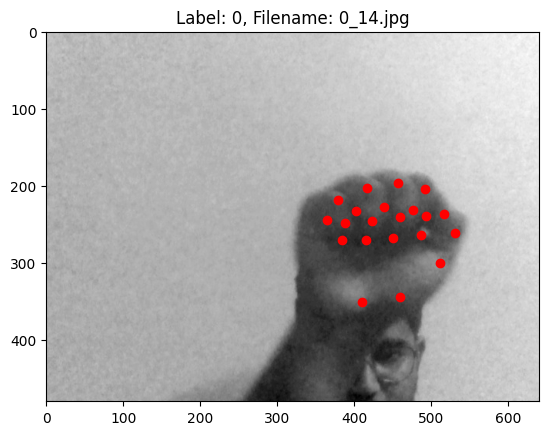

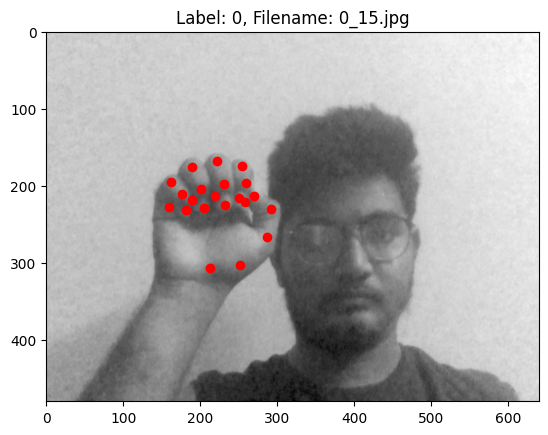

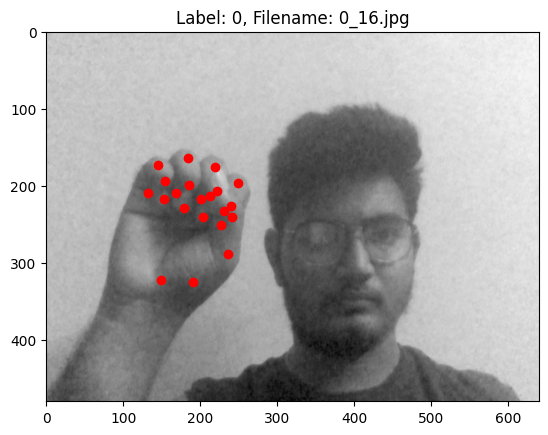

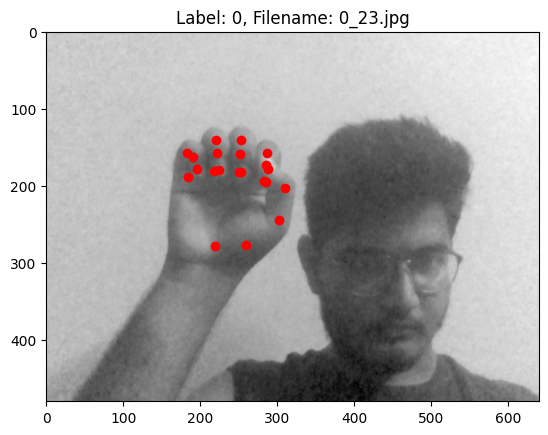

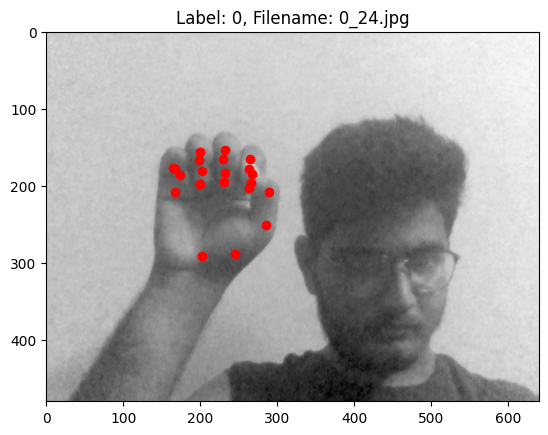

In [4]:
# Visualize all images
import cv2
import os
import matplotlib.pyplot as plt
import mediapipe as mp
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

def extract_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks_array = [[landmark.x, landmark.y, landmark.z] for landmark in landmarks]
        return landmarks_array
    return None

# Function to visualize landmarks on an image
def visualize_landmarks(image, landmarks, label, filename):
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}, Filename: {filename}")
    for landmark in landmarks:
        plt.plot(landmark[0] * image.shape[1], landmark[1] * image.shape[0], 'ro')
    plt.show()
def get_all_images_from_subdirs(root_path, valid_extensions):
    image_paths = []
    for subdir, _, files in os.walk(root_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in valid_extensions:
                image_paths.append(os.path.join(subdir, file))
    return image_paths

# Path to your dataset
source_directory = 'D:/B Tech/IV Year/project/project new/dataset_mediapipe'  # replace with your dataset path
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# Get all image paths
image_files = get_all_images_from_subdirs(source_directory, valid_extensions)
print(f"Found {len(image_files)} valid images in the directory.")

for image_path in image_files[:5]:  # Adjust the number as required
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Failed to load {image_path}")
        continue
    
    landmarks = extract_hand_landmarks(img)
    label = os.path.basename(os.path.dirname(image_path))  # Extracting label from directory name
    filename = os.path.basename(image_path)
    if landmarks:
        visualize_landmarks(img, landmarks, label, filename)
    else:
        print(f"No landmarks detected for {image_path}")


In [5]:
#Training
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

def extract_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks_array = [[landmark.x, landmark.y, landmark.z] for landmark in landmarks]
        return landmarks_array
    return None

def landmarks_to_heatmap(landmarks, img_size=(128, 128), blob_size=5):
    heatmap = np.zeros(img_size)
    for landmark in landmarks:
        x, y = int(landmark[0] * img_size[0]), int(landmark[1] * img_size[1])
        cv2.circle(heatmap, (x, y), blob_size, (255, 255, 255), -1)
    return heatmap

def preprocess_image(img, img_size=(128, 128)):
    landmarks = extract_hand_landmarks(img)
    if landmarks:
        heatmap = landmarks_to_heatmap(landmarks, img_size)
        return heatmap / 255.0
    return None
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
def load_images_from_folder(folder_name):
    images = []
    labels = []
    for filename in os.listdir(folder_name):
        img = cv2.imread(os.path.join(folder_name, filename))
        if img is not None:
            images.append(img)
            labels.append(folder_name)
    return images, labels

img_size = (128, 128)
all_images = []
all_labels = []

root_dataset_path = 'D:/B Tech/IV Year/project/project new/dataset_mediapipe'
for gesture_name in os.listdir(root_dataset_path):
    images, labels = load_images_from_folder(os.path.join(root_dataset_path, gesture_name))
    all_images.extend(images)
    all_labels.extend(labels)

preprocessed_data = [preprocess_image(img, img_size) for img in all_images]
processed_images, all_labels = zip(*[(data, label) for data, label in zip(preprocessed_data, all_labels) if data is not None])

unique_labels = list(set(all_labels))
int_labels = [unique_labels.index(label) for label in all_labels]

X_train, X_temp, y_train, y_temp = train_test_split(processed_images, int_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fit the Data Generator
X_train_reshaped = np.array(X_train).reshape((-1, img_size[0], img_size[1], 1))
datagen.fit(X_train_reshaped)
l2_strength = 0.01
feature_extractor = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength), input_shape=img_size + (1,)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(len(unique_labels), activation='softmax', kernel_regularizer=l2(l2_strength))
])

feature_extractor.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
batch_size = 16
history = feature_extractor.fit(datagen.flow(X_train_reshaped, to_categorical(y_train, num_classes=len(unique_labels)), batch_size=batch_size),
                                epochs=80,
                                validation_data=(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)),
                                                 to_categorical(y_val, num_classes=len(unique_labels))),
                                callbacks=[early_stopping])

feature_extractor.pop()
X_train_features = feature_extractor.predict(np.array(X_train).reshape((-1, img_size[0], img_size[1], 1)))
X_val_features = feature_extractor.predict(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)))
X_test_features = feature_extractor.predict(np.array(X_test).reshape((-1, img_size[0], img_size[1], 1)))

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_features, y_train)

y_val_pred = dt_classifier.predict(X_val_features)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_accuracy}")

y_test_pred = dt_classifier.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/80
18/18 [==============================] - 43s 2s/step - loss: 3.0355 - accuracy: 0.0932 - val_loss: 2.9510 - val_accuracy: 0.1000
Epoch 2/80
18/18 [==============================] - 9s 476ms/step - loss: 2.8176 - accuracy: 0.1541 - val_loss: 2.7638 - val_accuracy: 0.1000
Epoch 3/80
18/18 [==============================] - 10s 567ms/step - loss: 2.6523 - accuracy: 0.1362 - val_loss: 2.5827 - val_accuracy: 0.0833
Epoch 4/80
18/18 [==============================] - 9s 476ms/step - loss: 2.5512 - accuracy: 0.1649 - val_loss: 2.4746 - val_accuracy: 0.1667
Epoch 5/80
18/18 [==============================] - 8s 449ms/step - loss: 2.5021 - accuracy: 0.1577 - val_loss: 2.4815 - val_accuracy: 0.1667
Epoch 6/80
18/18 [==============================] - 9s 473ms/step - loss: 2.4528 - accuracy: 0.1434 - val_loss: 2.4201 - val_accuracy: 0.1000
Epoch 7/80
18/18 [==============================] - 8s 445ms/step - loss: 2.4422 - accuracy: 0.1326 - val_loss: 2.3889 - val_accuracy: 0.2000
Epoch 8

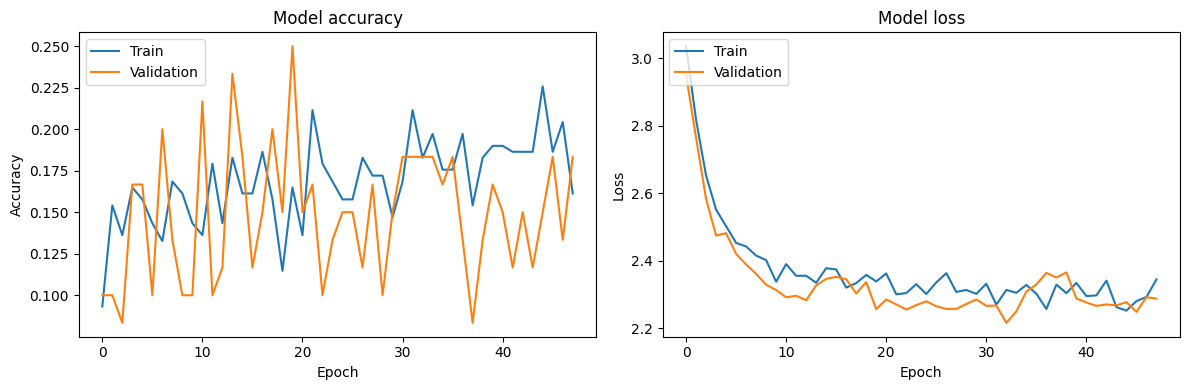

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [7]:
feature_extractor.save('cnn_model_3_mediapipe.h5')


C:\Users\lant\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
import joblib

joblib.dump(dt_classifier, 'dt_classifier_3_mediapipe.pkl')


['dt_classifier_3_mediapipe.pkl']

In [9]:
import pickle

with open('unique_labels_3_mediapipe.pkl', 'wb') as f:
    pickle.dump(unique_labels, f)


In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import pickle

KeyboardInterrupt: 

In [31]:
# Real time prediction
# Initialize mediapipe hands module
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

def extract_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks_array = [[landmark.x, landmark.y, landmark.z] for landmark in landmarks]
        return landmarks_array
    return None

def landmarks_to_heatmap(landmarks, img_size=(128, 128), blob_size=5):
    heatmap = np.zeros(img_size)
    for landmark in landmarks:
        x, y = int(landmark[0] * img_size[0]), int(landmark[1] * img_size[1])
        cv2.circle(heatmap, (x, y), blob_size, (255, 255, 255), -1)
    return heatmap

def preprocess_image(img, img_size=(128, 128)):
    landmarks = extract_hand_landmarks(img)
    if landmarks:
        heatmap = landmarks_to_heatmap(landmarks, img_size)
        return heatmap / 255.0
    return None
# Load the trained models and unique_labels
feature_extractor = load_model('cnn_model_3_mediapipe.h5')
dt_classifier = joblib.load('dt_classifier_3_mediapipe.pkl')
with open('unique_labels_3_mediapipe.pkl', 'rb') as f:
    unique_labels = pickle.load(f)

# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    scale_factor = 1.5  # Adjust this value as needed
    new_width = int(frame.shape[1] * scale_factor)
    new_height = int(frame.shape[0] * scale_factor)
    resized_frame = cv2.resize(frame, (new_width, new_height))
    # Check if frame captured successfully
    if not ret:
        break

    # Preprocess the frame
    processed_img = preprocess_image(resized_frame, img_size)
    
    if processed_img is not None:
        processed_img_reshaped = processed_img.reshape((-1, img_size[0], img_size[1], 1))
        
        # Extract features from CNN
        features = feature_extractor.predict(processed_img_reshaped)
        
        # Predict using the Decision Tree classifier
        prediction = dt_classifier.predict(features)
        
        # Convert integer label back to string label
        predicted_gesture = unique_labels[prediction[0]]
        
        # Display the result on the frame
        # Instead of a fixed position, compute the position dynamically
        text_position = (int(resized_frame.shape[1] * 0.05), int(resized_frame.shape[0] * 0.05))

        cv2.putText(resized_frame, predicted_gesture, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)

    # Display the frame
    cv2.imshow('Gesture Recognition', resized_frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 1s 1s/step


## Dataset Creation

In [137]:
#Dataset creation according to hand landmarks
import cv2
import os
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def extract_hand_landmarks(img):
    # Convert the BGR image to RGB
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Process the image and get the hand landmarks
    results = hands.process(rgb_img)
    
    # If landmarks are found, return them, otherwise return None
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        return [(int(landmark.x * img.shape[1]), int(landmark.y * img.shape[0])) for landmark in landmarks]
    else:
        return None

# Function to visualize landmarks on an image
def visualize_landmarks_on_frame(frame, landmarks):
    frame_with_landmarks = frame.copy()
    for landmark in landmarks:
        cv2.circle(frame_with_landmarks, (int(landmark[0] * frame.shape[1]), int(landmark[1] * frame.shape[0])), 5, (0, 0, 255), -1)
    return frame_with_landmarks

# Initialize video capture for webcam
cap = cv2.VideoCapture(0)

# When u save this file in your computer change this directory/path accordingly
base_directory = "D:/B Tech/IV Year/project/project new/dataset_mediapipe"  # replace with the base path of your dataset

# Display available gesture folders and ask user which gesture they are capturing
subfolders = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
print("Available gestures: ")
for folder in subfolders:
    print(folder)

folder_name = input("Enter the name of the gesture you're capturing (as displayed above): ")
save_directory = os.path.join(base_directory, folder_name)

if not os.path.exists(save_directory):
    print(f"Warning: {save_directory} does not exist. Creating it now.")
    os.makedirs(save_directory)

# Find the largest numbered image in the directory for naming continuity
# Find the largest numbered image in the directory for naming continuity
existing_files = os.listdir(save_directory)
existing_indices = [int(f.split(".jpg")[0].split(f"{folder_name}_")[1]) for f in existing_files if f.startswith(f"{folder_name}_") and f.endswith(".jpg")]
counter = max(existing_indices, default=-1) + 1

while True:
    ret, frame = cap.read()  # Read a frame
    if not ret:
        print("Failed to grab frame")
        break

    # Extract landmarks from the frame
    landmarks = extract_hand_landmarks(frame)

    # Check if 21 landmarks are detected and visualize them
    if landmarks and len(landmarks) == 21:
        frame = visualize_landmarks_on_frame(frame, landmarks)

    # Show the frame
    cv2.imshow("Hand Landmarks Detection", frame)

    key = cv2.waitKey(1) & 0xFF
    
    # Capture image on 'c' key press
    # Capture image on 'c' key press
    if key == ord('c') and landmarks and len(landmarks) == 21:
        filename = os.path.join(save_directory, f"{folder_name}_{counter}.jpg")
        cv2.imwrite(filename, frame)
        counter += 1
        print(f"Image saved to {filename}")
    # Quit on 'q' key press
    elif key == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


Available gestures: 
.ipynb_checkpoints
0
1
10
2
3
4
5
6
7
8
9
nohands


Enter the name of the gesture you're capturing (as displayed above):  10


Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_42.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_43.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_44.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_45.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_46.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_47.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_48.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_49.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_50.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_51.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10_52.jpg
Image saved to D:/B Tech/IV Year/project/project new/dataset_mediapipe\10\10

# Preprocessing


### 1. Greyscale Images with Hand Landmarks

Found 45 valid images in the 4 directory.


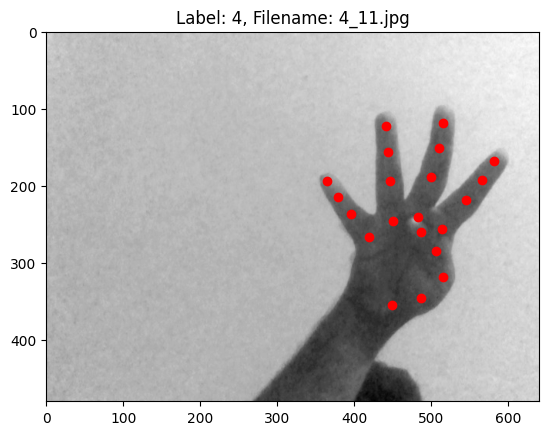

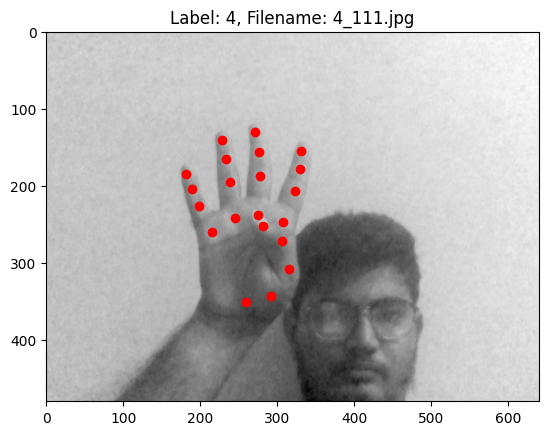

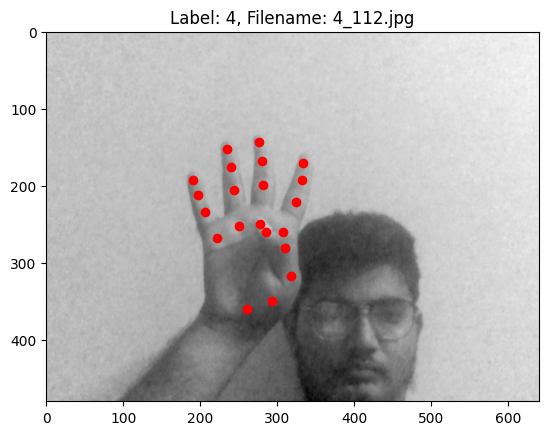

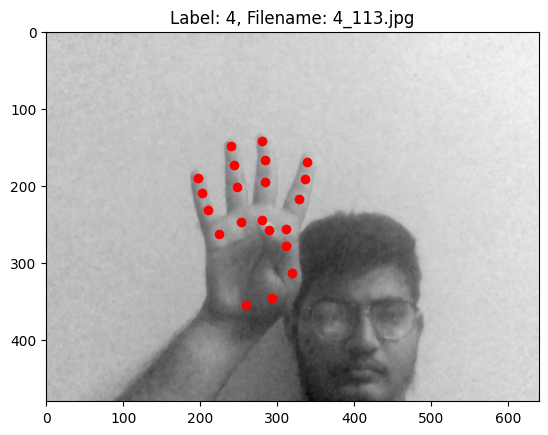

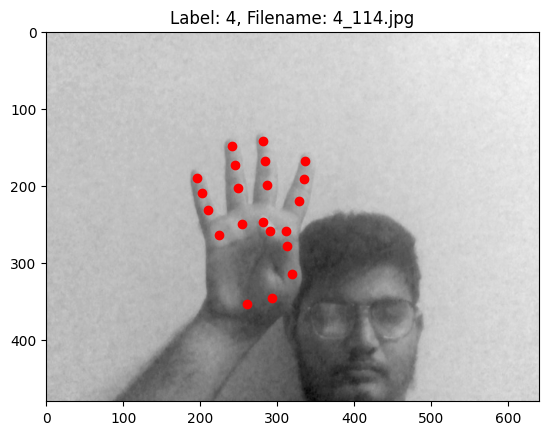

In [19]:
# visualize hand landmarks label by label i.e folder by folder
# Path to your dataset
source_directory = 'D:/B Tech/IV Year/project/project new/dataset_mediapipe'  # replace with your dataset path
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

label_to_visualize = "4"
label_directory = os.path.join(source_directory, label_to_visualize)

# Function to get all images from a specific directory
def get_images_from_directory(dir_path, valid_extensions):
    image_paths = []
    for file in os.listdir(dir_path):
        if os.path.splitext(file)[1].lower() in valid_extensions:
            image_paths.append(os.path.join(dir_path, file))
    return image_paths

# Function to visualize landmarks on an image
def visualize_landmarks(image, landmarks, label, filename):
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}, Filename: {filename}")
    for landmark in landmarks:
        plt.plot(landmark[0] * image.shape[1], landmark[1] * image.shape[0], 'ro')
    plt.show()
def get_all_images_from_subdirs(root_path, valid_extensions):
    image_paths = []
    for subdir, _, files in os.walk(root_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in valid_extensions:
                image_paths.append(os.path.join(subdir, file))
    return image_paths


# Get image paths from the specific label directory
image_files = get_images_from_directory(label_directory, valid_extensions)
print(f"Found {len(image_files)} valid images in the {label_to_visualize} directory.")

for image_path in image_files[:5]:  # Adjust the number as required
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Failed to load {image_path}")
        continue
    
    landmarks = extract_hand_landmarks(img)
    
    label = os.path.basename(os.path.dirname(image_path))  # Extracting label from directory name
    filename = os.path.basename(image_path)
    
    if landmarks:
        visualize_landmarks(img, landmarks, label, filename)
    else:
        print(f"No landmarks detected for {image_path}")


### 2. Convert to Heatmaps

In [22]:
#visualize heatmaps
import cv2
import numpy as np
import mediapipe as mp
# Assuming you've already defined your preprocessing functions and loaded your dataset into 'all_images'
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
# Function to load images and labels
def load_images_from_folder(folder_name):
    images = []
    labels = []
    for filename in os.listdir(folder_name):
        img = cv2.imread(os.path.join(folder_name, filename))
        if img is not None:
            images.append(img)
            labels.append(folder_name)
    return images, labels
root_dataset_path = 'D:/B Tech/IV Year/project/project new/dataset_mediapipe'
# Load dataset
img_size = (128, 128)
def extract_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks_array = [[landmark.x, landmark.y, landmark.z] for landmark in landmarks]
        return landmarks_array
    return None

def landmarks_to_heatmap(landmarks, img_size=(128, 128), blob_size=5):
    heatmap = np.zeros(img_size)
    for landmark in landmarks:
        x, y = int(landmark[0] * img_size[0]), int(landmark[1] * img_size[1])
        cv2.circle(heatmap, (x, y), blob_size, (255, 255, 255), -1)
    return heatmap

def preprocess_image(img, img_size=(128, 128)):
    landmarks = extract_hand_landmarks(img)
    if landmarks:
        heatmap = landmarks_to_heatmap(landmarks, img_size)
        return heatmap / 255.0
    return None
# Specify the label you want to visualize
desired_label = 'D:/B Tech/IV Year/project/project new/dataset_mediapipe/4'  # Replace this with the label you're interested in

images, labels = load_images_from_folder(os.path.join(root_dataset_path, desired_label))

# Preprocess images to generate heatmaps
preprocessed_data = [preprocess_image(img, img_size) for img in images]

# Convert None values to a placeholder (black image)
preprocessed_data = [data if data is not None else np.zeros(img_size) for data in preprocessed_data]

# Display the heatmaps for the desired label
#for i in range(5):
for i in range(len(preprocessed_data)): # All images are displayed one after the other
    cv2.imshow(f"Heatmap {i+1}", preprocessed_data[i])
    cv2.waitKey(0)  # Waits for a key event
    cv2.destroyAllWindows()

### Initial training

In [ ]:
# This part is the initial part of training.....

In [ ]:
# It has initial accuracies, different preprocessing techniwues, dataset etc.

In [11]:
#Training
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

def extract_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks_array = [[landmark.x, landmark.y, landmark.z] for landmark in landmarks]
        return landmarks_array
    return None

def landmarks_to_heatmap(landmarks, img_size=(128, 128), blob_size=5):
    heatmap = np.zeros(img_size)
    for landmark in landmarks:
        x, y = int(landmark[0] * img_size[0]), int(landmark[1] * img_size[1])
        cv2.circle(heatmap, (x, y), blob_size, (255, 255, 255), -1)
    return heatmap

def preprocess_image(img, img_size=(128, 128)):
    landmarks = extract_hand_landmarks(img)
    if landmarks:
        heatmap = landmarks_to_heatmap(landmarks, img_size)
        return heatmap / 255.0
    return None
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
def load_images_from_folder(folder_name):
    images = []
    labels = []
    for filename in os.listdir(folder_name):
        img = cv2.imread(os.path.join(folder_name, filename))
        if img is not None:
            images.append(img)
            labels.append(folder_name)
    return images, labels

img_size = (128, 128)
all_images = []
all_labels = []

root_dataset_path = 'D:/B Tech/IV Year/project/project new/dataset_mediapipe'
for gesture_name in os.listdir(root_dataset_path):
    images, labels = load_images_from_folder(os.path.join(root_dataset_path, gesture_name))
    all_images.extend(images)
    all_labels.extend(labels)

preprocessed_data = [preprocess_image(img, img_size) for img in all_images]
processed_images, all_labels = zip(*[(data, label) for data, label in zip(preprocessed_data, all_labels) if data is not None])

unique_labels = list(set(all_labels))
int_labels = [unique_labels.index(label) for label in all_labels]

X_train, X_temp, y_train, y_temp = train_test_split(processed_images, int_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fit the Data Generator
X_train_reshaped = np.array(X_train).reshape((-1, img_size[0], img_size[1], 1))
datagen.fit(X_train_reshaped)
l2_strength = 0.01
feature_extractor = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength), input_shape=img_size + (1,)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(len(unique_labels), activation='softmax', kernel_regularizer=l2(l2_strength))
])

feature_extractor.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
batch_size = 32
history = feature_extractor.fit(datagen.flow(X_train_reshaped, to_categorical(y_train, num_classes=len(unique_labels)), batch_size=batch_size),
                                epochs=100,
                                validation_data=(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)),
                                                 to_categorical(y_val, num_classes=len(unique_labels))),
                                callbacks=[early_stopping])

feature_extractor.pop()
X_train_features = feature_extractor.predict(np.array(X_train).reshape((-1, img_size[0], img_size[1], 1)))
X_val_features = feature_extractor.predict(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)))
X_test_features = feature_extractor.predict(np.array(X_test).reshape((-1, img_size[0], img_size[1], 1)))

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_features, y_train)

y_val_pred = dt_classifier.predict(X_val_features)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_accuracy}")

y_test_pred = dt_classifier.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/100
9/9 [==============================] - 9s 782ms/step - loss: 3.5469 - accuracy: 0.1254 - val_loss: 3.4371 - val_accuracy: 0.1167
Epoch 2/100
9/9 [==============================] - 6s 664ms/step - loss: 3.2635 - accuracy: 0.1541 - val_loss: 3.1834 - val_accuracy: 0.1833
Epoch 3/100
9/9 [==============================] - 6s 674ms/step - loss: 3.0233 - accuracy: 0.1685 - val_loss: 2.9769 - val_accuracy: 0.1500
Epoch 4/100
9/9 [==============================] - 6s 651ms/step - loss: 2.8354 - accuracy: 0.1470 - val_loss: 2.8175 - val_accuracy: 0.1333
Epoch 5/100
9/9 [==============================] - 6s 655ms/step - loss: 2.7005 - accuracy: 0.1720 - val_loss: 2.6502 - val_accuracy: 0.1833
Epoch 6/100
9/9 [==============================] - 6s 657ms/step - loss: 2.6175 - accuracy: 0.1649 - val_loss: 2.5327 - val_accuracy: 0.2167
Epoch 7/100
9/9 [==============================] - 6s 659ms/step - loss: 2.5738 - accuracy: 0.1254 - val_loss: 2.4914 - val_accuracy: 0.2333
Epoch 8/100
9

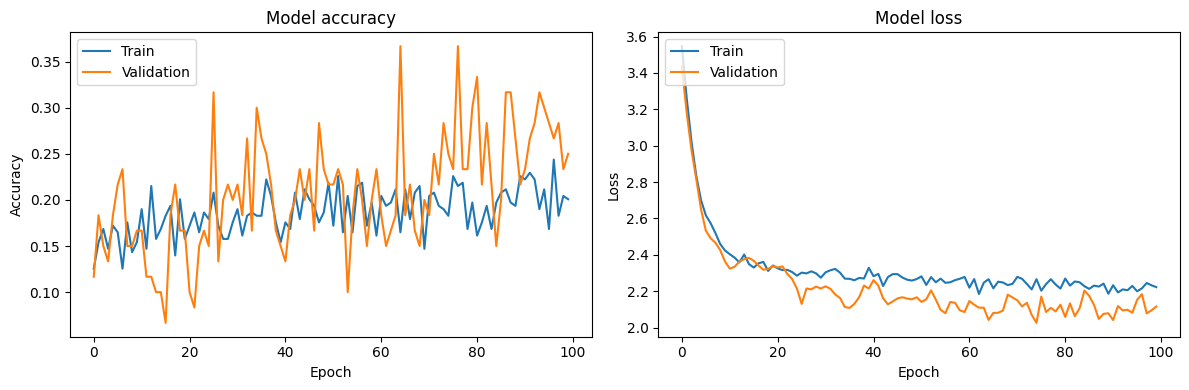

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [18]:
#Training
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

def extract_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks_array = [[landmark.x, landmark.y, landmark.z] for landmark in landmarks]
        return landmarks_array
    return None

def landmarks_to_heatmap(landmarks, img_size=(128, 128), blob_size=5):
    heatmap = np.zeros(img_size)
    for landmark in landmarks:
        x, y = int(landmark[0] * img_size[0]), int(landmark[1] * img_size[1])
        cv2.circle(heatmap, (x, y), blob_size, (255, 255, 255), -1)
    return heatmap

def preprocess_image(img, img_size=(128, 128)):
    landmarks = extract_hand_landmarks(img)
    if landmarks:
        heatmap = landmarks_to_heatmap(landmarks, img_size)
        return heatmap / 255.0
    return None
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
def load_images_from_folder(folder_name):
    images = []
    labels = []
    for filename in os.listdir(folder_name):
        img = cv2.imread(os.path.join(folder_name, filename))
        if img is not None:
            images.append(img)
            labels.append(folder_name)
    return images, labels

img_size = (128, 128)
all_images = []
all_labels = []

root_dataset_path = 'D:/B Tech/IV Year/project/project new/dataset_mediapipe'
for gesture_name in os.listdir(root_dataset_path):
    images, labels = load_images_from_folder(os.path.join(root_dataset_path, gesture_name))
    all_images.extend(images)
    all_labels.extend(labels)

preprocessed_data = [preprocess_image(img, img_size) for img in all_images]
processed_images, all_labels = zip(*[(data, label) for data, label in zip(preprocessed_data, all_labels) if data is not None])

unique_labels = list(set(all_labels))
int_labels = [unique_labels.index(label) for label in all_labels]

X_train, X_temp, y_train, y_temp = train_test_split(processed_images, int_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fit the Data Generator
X_train_reshaped = np.array(X_train).reshape((-1, img_size[0], img_size[1], 1))
datagen.fit(X_train_reshaped)
l2_strength = 0.01
feature_extractor = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength), input_shape=img_size + (1,)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (2, 2), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(2, 2),
    Dropout(0.15),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(2, 2),
    Dropout(0.15),
    Conv2D(32, (5, 5), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(len(unique_labels), activation='softmax', kernel_regularizer=l2(l2_strength))
])

feature_extractor.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
batch_size = 32
history = feature_extractor.fit(datagen.flow(X_train_reshaped, to_categorical(y_train, num_classes=len(unique_labels)), batch_size=batch_size),
                                epochs=100,
                                validation_data=(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)),
                                                 to_categorical(y_val, num_classes=len(unique_labels))),
                                callbacks=[early_stopping])

feature_extractor.pop()
X_train_features = feature_extractor.predict(np.array(X_train).reshape((-1, img_size[0], img_size[1], 1)))
X_val_features = feature_extractor.predict(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)))
X_test_features = feature_extractor.predict(np.array(X_test).reshape((-1, img_size[0], img_size[1], 1)))

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_features, y_train)

y_val_pred = dt_classifier.predict(X_val_features)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_accuracy}")

y_test_pred = dt_classifier.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/100
9/9 [==============================] - 19s 882ms/step - loss: 4.2365 - accuracy: 0.1326 - val_loss: 4.0976 - val_accuracy: 0.1000
Epoch 2/100
9/9 [==============================] - 6s 669ms/step - loss: 3.9135 - accuracy: 0.1470 - val_loss: 3.8067 - val_accuracy: 0.1000
Epoch 3/100
9/9 [==============================] - 9s 664ms/step - loss: 3.6286 - accuracy: 0.1541 - val_loss: 3.5445 - val_accuracy: 0.1000
Epoch 4/100
9/9 [==============================] - 7s 670ms/step - loss: 3.4003 - accuracy: 0.1434 - val_loss: 3.3318 - val_accuracy: 0.1000
Epoch 5/100
9/9 [==============================] - 6s 612ms/step - loss: 3.2007 - accuracy: 0.1649 - val_loss: 3.1660 - val_accuracy: 0.1000
Epoch 6/100
9/9 [==============================] - 6s 610ms/step - loss: 3.0427 - accuracy: 0.1505 - val_loss: 3.0281 - val_accuracy: 0.1333
Epoch 7/100
9/9 [==============================] - 5s 594ms/step - loss: 2.9150 - accuracy: 0.1434 - val_loss: 2.9170 - val_accuracy: 0.1667
Epoch 8/100


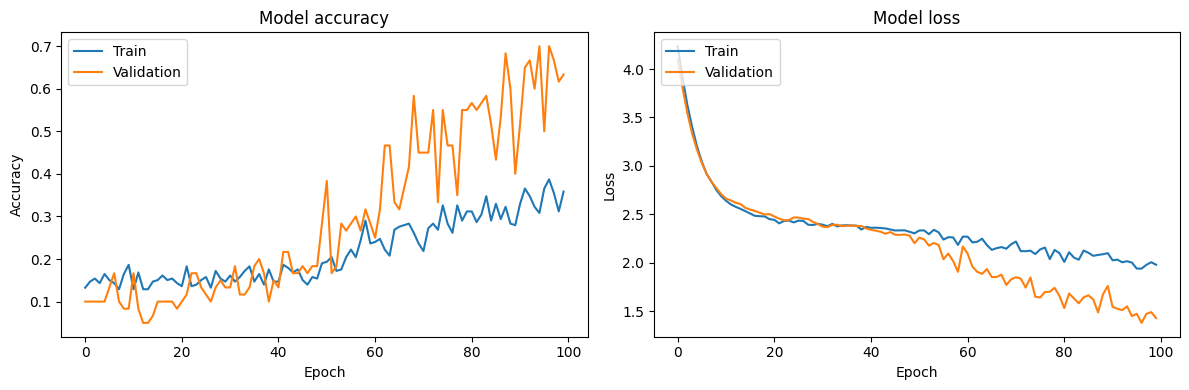

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# Training

In [25]:
#Training
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

def extract_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks_array = [[landmark.x, landmark.y, landmark.z] for landmark in landmarks]
        return landmarks_array
    return None

def landmarks_to_heatmap(landmarks, img_size=(128, 128), blob_size=5):
    heatmap = np.zeros(img_size)
    for landmark in landmarks:
        x, y = int(landmark[0] * img_size[0]), int(landmark[1] * img_size[1])
        cv2.circle(heatmap, (x, y), blob_size, (255, 255, 255), -1)
    return heatmap

def preprocess_image(img, img_size=(128, 128)):
    landmarks = extract_hand_landmarks(img)
    if landmarks:
        heatmap = landmarks_to_heatmap(landmarks, img_size)
        return heatmap / 255.0
    return None
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
def load_images_from_folder(folder_name):
    images = []
    labels = []
    for filename in os.listdir(folder_name):
        img = cv2.imread(os.path.join(folder_name, filename))
        if img is not None:
            images.append(img)
            labels.append(folder_name)
    return images, labels

img_size = (128, 128)
all_images = []
all_labels = []

root_dataset_path = 'D:/B Tech/IV Year/project/project new/dataset_mediapipe'
for gesture_name in os.listdir(root_dataset_path):
    images, labels = load_images_from_folder(os.path.join(root_dataset_path, gesture_name))
    all_images.extend(images)
    all_labels.extend(labels)

preprocessed_data = [preprocess_image(img, img_size) for img in all_images]
processed_images, all_labels = zip(*[(data, label) for data, label in zip(preprocessed_data, all_labels) if data is not None])

unique_labels = list(set(all_labels))
int_labels = [unique_labels.index(label) for label in all_labels]

X_train, X_temp, y_train, y_temp = train_test_split(processed_images, int_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fit the Data Generator
X_train_reshaped = np.array(X_train).reshape((-1, img_size[0], img_size[1], 1))
datagen.fit(X_train_reshaped)
l2_strength = 0.01
feature_extractor = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength), input_shape=img_size + (1,)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (5, 5), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(4, 4),
    Dropout(0.25),
    Conv2D(64, (5, 5), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D(4, 4),
    Dropout(0.25),
    Flatten(),
    Dense(len(unique_labels), activation='softmax', kernel_regularizer=l2(l2_strength))
])

feature_extractor.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
batch_size = 32
history = feature_extractor.fit(datagen.flow(X_train_reshaped, to_categorical(y_train, num_classes=len(unique_labels)), batch_size=batch_size),
                                epochs=130,
                                validation_data=(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)),
                                                 to_categorical(y_val, num_classes=len(unique_labels))),
                                callbacks=[early_stopping])

feature_extractor.pop()
X_train_features = feature_extractor.predict(np.array(X_train).reshape((-1, img_size[0], img_size[1], 1)))
X_val_features = feature_extractor.predict(np.array(X_val).reshape((-1, img_size[0], img_size[1], 1)))
X_test_features = feature_extractor.predict(np.array(X_test).reshape((-1, img_size[0], img_size[1], 1)))

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_features, y_train)

y_val_pred = dt_classifier.predict(X_val_features)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_accuracy}")

y_test_pred = dt_classifier.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/130
9/9 [==============================] - 29s 2s/step - loss: 3.6089 - accuracy: 0.1039 - val_loss: 3.5016 - val_accuracy: 0.1167
Epoch 2/130
9/9 [==============================] - 12s 1s/step - loss: 3.3711 - accuracy: 0.1577 - val_loss: 3.2995 - val_accuracy: 0.0833
Epoch 3/130
9/9 [==============================] - 12s 1s/step - loss: 3.1708 - accuracy: 0.1685 - val_loss: 3.1260 - val_accuracy: 0.1000
Epoch 4/130
9/9 [==============================] - 12s 1s/step - loss: 3.0269 - accuracy: 0.1326 - val_loss: 3.0070 - val_accuracy: 0.1000
Epoch 5/130
9/9 [==============================] - 11s 1s/step - loss: 2.9298 - accuracy: 0.1434 - val_loss: 2.8986 - val_accuracy: 0.1000
Epoch 6/130
9/9 [==============================] - 12s 1s/step - loss: 2.8154 - accuracy: 0.1505 - val_loss: 2.8274 - val_accuracy: 0.1000
Epoch 7/130
9/9 [==============================] - 12s 1s/step - loss: 2.7644 - accuracy: 0.1505 - val_loss: 2.7600 - val_accuracy: 0.1667
Epoch 8/130
9/9 [==========

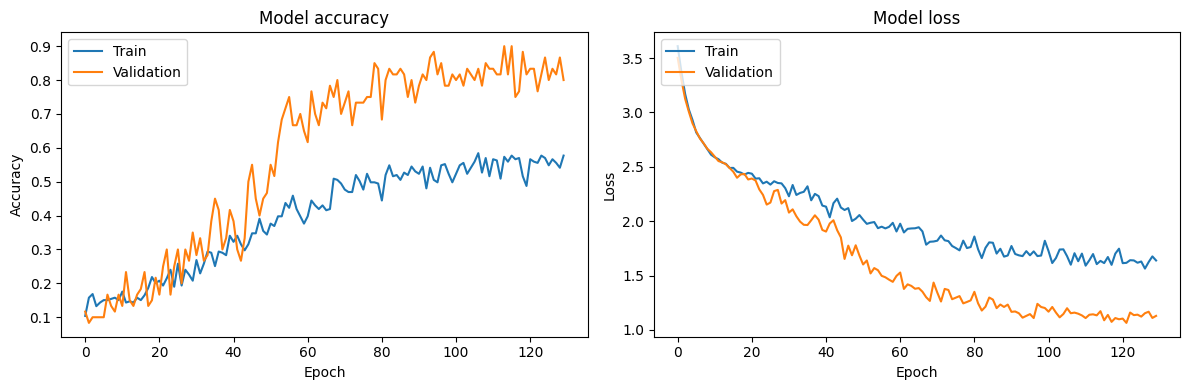

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [23]:
# Precision, Recall, F1 Score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')



KeyboardInterrupt



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example metrics and values (replace with your actual values)
metrics = ['F1 Score', 'Recall', 'Precision', 'Training Accuracy', 'Testing Accuracy']
cnn_values = [0.8, 0.7, 0.75, 0.9, 0.85]
dt_values = [0.6, 0.5, 0.65, 0.8, 0.75]
hybrid_values = [0.75, 0.65, 0.7, 0.88, 0.82]

# Check if the lengths match
if len(metrics) == len(cnn_values) == len(dt_values) == len(hybrid_values):
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)

    # Plot each model with labels
    ax.plot(angles, cnn_values + [cnn_values[0]], linewidth=2, linestyle='solid', label='CNN')
    ax.fill(angles, cnn_values + [cnn_values[0]], alpha=0.4)

    ax.plot(angles, dt_values + [dt_values[0]], linewidth=2, linestyle='solid', label='DT')
    ax.fill(angles, dt_values + [dt_values[0]], alpha=0.4)

    ax.plot(angles, hybrid_values + [hybrid_values[0]], linewidth=2, linestyle='solid', label='Hybrid')
    ax.fill(angles, hybrid_values + [hybrid_values[0]], alpha=0.4)

    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Comparison - Metrics Radar Chart')
    plt.show()

else:
    print("Error: The lengths of metrics and values are not the same.")


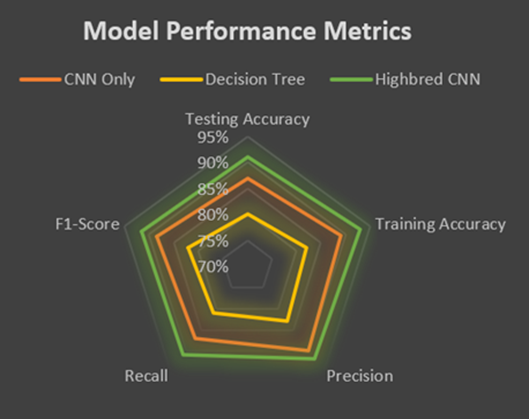

# Save the CNN feature extractor

In [27]:
feature_extractor.save('cnn_model_3_mediapipe_90.h5')


C:\Users\lant\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Save the Decision Tree model

In [28]:
import joblib

joblib.dump(dt_classifier, 'dt_classifier_3_mediapipe_90.pkl')


['dt_classifier_3_mediapipe_90.pkl']

# Save the Gesture Labels

In [29]:
import pickle

with open('unique_labels_3_mediapipe_90.pkl', 'wb') as f:
    pickle.dump(unique_labels, f)


In [32]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

def extract_hand_landmarks(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks_array = [[landmark.x, landmark.y, landmark.z] for landmark in landmarks]
        return landmarks_array
    return None

def landmarks_to_heatmap(landmarks, img_size=(128, 128), blob_size=5):
    heatmap = np.zeros(img_size)
    for landmark in landmarks:
        x, y = int(landmark[0] * img_size[0]), int(landmark[1] * img_size[1])
        cv2.circle(heatmap, (x, y), blob_size, (255, 255, 255), -1)
    return heatmap

def preprocess_image(img, img_size=(128, 128)):
    landmarks = extract_hand_landmarks(img)
    if landmarks:
        heatmap = landmarks_to_heatmap(landmarks, img_size)
        return heatmap / 255.0
    return None

feature_extractor = load_model("cnn_model_3_mediapipe_90.h5")
dt_classifier = joblib.load('dt_classifier_3_mediapipe_90.pkl')
unique_labels = joblib.load('unique_labels_3_mediapipe_90.pkl')

def real_time_prediction(model, feature_extractor):
       # Initialize webcam
    cap = cv2.VideoCapture(0)

    while True:
    # Capture frame-by-frame
        ret, frame = cap.read()
        scale_factor = 1.5  # Adjust this value as needed
        new_width = int(frame.shape[1] * scale_factor)
        new_height = int(frame.shape[0] * scale_factor)
        resized_frame = cv2.resize(frame, (new_width, new_height))
    # Check if frame captured successfully
        if not ret:
            break

    # Preprocess the frame
        processed_img = preprocess_image(resized_frame, img_size)
    
        if processed_img is not None:
            processed_img_reshaped = processed_img.reshape((-1, img_size[0], img_size[1], 1))
        
        # Extract features from CNN
            features = feature_extractor.predict(processed_img_reshaped)
        
        # Predict using the Decision Tree classifier
            prediction = dt_classifier.predict(features)
            
            # Convert integer label back to string label
            predicted_gesture = unique_labels[prediction[0]]
        
        # Display the result on the frame
        # Instead of a fixed position, compute the position dynamically
            text_position = (int(resized_frame.shape[1] * 0.05), int(resized_frame.shape[0] * 0.05))

            cv2.putText(resized_frame, predicted_gesture, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)

    # Display the frame
        cv2.imshow('Gesture Recognition', resized_frame)

    # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the capture
    cap.release()
    cv2.destroyAllWindows()

real_time_prediction(dt_classifier, feature_extractor)

1/1 [==============================] - 0s 42ms/step
